In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import numpy as np
from acquire import remove_stopwords, basic_clean, tokenize, prep_and_split_data
from prepare_jag import basic_clean3
import re
from re import search
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras
import io
import os
import shutil
import string

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

from nltk.corpus import stopwords
import nltk

Download the data from the [Kaggle Competition Site](https://www.kaggle.com/c/medicalnotes-2019/data)

# Data Dictionary
descriptor: the value held in the 'feature_text' column. These are features that describe the individual.

In [2]:
# Read csv files into a Pandas dataframe.
features = pd.read_csv('features.csv')

In [3]:
notes = pd.read_csv('patient_notes.csv')

In [4]:
train = pd.read_csv('train.csv')

In [5]:
train

,id,case_num,pn_num,feature_num,annotation,location
0,00016_000,0,16,0,['dad with recent heart attcak'],['696 724']
1,00016_001,0,16,1,"['mom with ""thyroid disease']",['668 693']
2,00016_002,0,16,2,['chest pressure'],['203 217']
3,00016_003,0,16,3,"['intermittent episodes', 'episode']","['70 91', '176 183']"
4,00016_004,0,16,4,['felt as if he were going to pass out'],['222 258']
...,...,...,...,...,...,...
14295,95333_912,9,95333,912,[],[]
14296,95333_913,9,95333,913,[],[]
14297,95333_914,9,95333,914,['photobia'],['274 282']
14298,95333_915,9,95333,915,['no sick contacts'],['421 437']


In [6]:
# Get familiar with the 'features' dataframe.
features

,feature_num,case_num,feature_text
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded
...,...,...,...
138,912,9,Family-history-of-migraines
139,913,9,Female
140,914,9,Photophobia
141,915,9,No-known-illness-contacts


# Set sights on target:
'feature_text' targeted

I will have to create a function that will iterate through the students' patient notes and identify the different ways different students express the descriptors.

Tentative plan: 
1. Rename {'case_num':'case', 'feature_text':'target'}
2. Rename {'pn_num':'note_id', 'case_num':'case', 'pn_history':'student_notes'}
3. Normalize the text in features.feature_text and notes.pn_history.
    * clean it
4. Create a dataframe that holds the original text and the clean.
5. Split data in train, validate, and test.

In [7]:
# Rename columns in the features dataframe.
features.rename(columns={'feature_num':'feature_id', 'case_num':'case', 'feature_text':'target'}, inplace=True)

In [8]:
# Verify
features

,feature_id,case,target
0,0,0,Family-history-of-MI-OR-Family-history-of-myoc...
1,1,0,Family-history-of-thyroid-disorder
2,2,0,Chest-pressure
3,3,0,Intermittent-symptoms
4,4,0,Lightheaded
...,...,...,...
138,912,9,Family-history-of-migraines
139,913,9,Female
140,914,9,Photophobia
141,915,9,No-known-illness-contacts


In [9]:
features.target.value_counts().head(50)

Female                                                                  7
Male                                                                    3
20-year                                                                 2
17-year                                                                 2
Nausea                                                                  2
35-year                                                                 2
Awakens-at-night                                                        1
Global-headache-OR-diffuse-headache                                     1
Duration-x-1-day                                                        1
Infertility-HX-OR-Infertility-history                                   1
Auditory-hallucination-once                                             1
No-known-illness-contacts                                               1
Lack-of-other-thyroid-symptoms                                          1
26-year                               

In [10]:
len(features.target)

143

In [11]:
# Rename columns in notes dataframe.
notes.rename(columns={'pn_num':'note_id', 'case_num':'case', 'pn_history':'student_notes'}, inplace=True)

In [12]:
# Verify
notes

,note_id,case,student_notes
0,0,0,"17-year-old male, has come to the student heal..."
1,1,0,17 yo male with recurrent palpitations for the...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...
4,4,0,17yo male with no pmh here for evaluation of p...
...,...,...,...
42141,95330,9,Ms. Madden is a 20 yo female presenting w/ the...
42142,95331,9,A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...
42143,95332,9,Ms. Madden is a 20yo female who presents with ...
42144,95333,9,Stephanie madden is a 20 year old woman compla...


In [13]:
# Check 'features' dataframe for null values and data types.
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   feature_id  143 non-null    int64 
 1   case        143 non-null    int64 
 2   target      143 non-null    object
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


# Takeaways
* The 'target' column holds values related to the individual patient. 
* There are no null values and the data types make sense.

In [14]:
# Check the type of values in the 'feature_text' column.
features.target.value_counts().head(50)

Female                                                                  7
Male                                                                    3
20-year                                                                 2
17-year                                                                 2
Nausea                                                                  2
35-year                                                                 2
Awakens-at-night                                                        1
Global-headache-OR-diffuse-headache                                     1
Duration-x-1-day                                                        1
Infertility-HX-OR-Infertility-history                                   1
Auditory-hallucination-once                                             1
No-known-illness-contacts                                               1
Lack-of-other-thyroid-symptoms                                          1
26-year                               

# Takeaways
* It seems as if they created a unique list of descriptors for each patient.

In [15]:
features.case.value_counts()

5    18
8    18
2    17
9    17
3    16
0    13
1    13
6    12
4    10
7     9
Name: case, dtype: int64

In [16]:
features.case.value_counts().describe()

count    10.000
mean     14.300
std       3.335
min       9.000
25%      12.250
50%      14.500
75%      17.000
max      18.000
Name: case, dtype: float64

# Takeaways
* Descriptors for each patient ranges from 9 - 18.
* Average amount of descriptors per patient is 14.

In [17]:
notes.case.value_counts()

3    9753
5    6909
4    5405
9    5151
8    4196
7    4101
0    2268
2    1958
6    1597
1     808
Name: case, dtype: int64

# Takeaways
* Student notes for patient_3 has close to 10,000 submissions.

In [18]:
def prep_text2(df, column, extra_words=[], exclude_words=['no','i']):
    '''
    This function take in a df and the string name for a text column with 
    option to pass lists for extra_words and exclude_words and
    returns a df with the text article title, original text, stemmed text,
    lemmatized text, cleaned, tokenized, & lemmatized text with stopwords removed.
    '''
    df['clean'] = df[column].apply(basic_clean)\
                            .apply(tokenize)\
                            .apply(remove_stopwords, 
                                   extra_words=extra_words, 
                                   exclude_words=exclude_words)
    return df[['case', column, 'clean']]

In [19]:
prep_text2(notes, 'student_notes')

,case,student_notes,clean
0,0,"17-year-old male, has come to the student heal...",17 year old male come student health clinic co...
1,0,17 yo male with recurrent palpitations for the...,17 yo male recurrent palpitations past 3 mo la...
2,0,Dillon Cleveland is a 17 y.o. male patient wit...,dillon cleveland 17 male patient no significan...
3,0,a 17 yo m c/o palpitation started 3 mos ago; \...,17 yo c palpitation started 3 mos ago nothing ...
4,0,17yo male with no pmh here for evaluation of p...,17yo male no pmh evaluation palpitations state...
...,...,...,...
42141,9,Ms. Madden is a 20 yo female presenting w/ the...,ms madden 20 yo female presenting w worst ha l...
42142,9,A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...,20 yo f came complain dull 8 10 headache assoc...
42143,9,Ms. Madden is a 20yo female who presents with ...,ms madden 20yo female presents headache 1 days...
42144,9,Stephanie madden is a 20 year old woman compla...,stephanie madden 20 year old woman complaining...


In [20]:
notes

,note_id,case,student_notes,clean
0,0,0,"17-year-old male, has come to the student heal...",17 year old male come student health clinic co...
1,1,0,17 yo male with recurrent palpitations for the...,17 yo male recurrent palpitations past 3 mo la...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...,dillon cleveland 17 male patient no significan...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...,17 yo c palpitation started 3 mos ago nothing ...
4,4,0,17yo male with no pmh here for evaluation of p...,17yo male no pmh evaluation palpitations state...
...,...,...,...,...
42141,95330,9,Ms. Madden is a 20 yo female presenting w/ the...,ms madden 20 yo female presenting w worst ha l...
42142,95331,9,A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...,20 yo f came complain dull 8 10 headache assoc...
42143,95332,9,Ms. Madden is a 20yo female who presents with ...,ms madden 20yo female presents headache 1 days...
42144,95333,9,Stephanie madden is a 20 year old woman compla...,stephanie madden 20 year old woman complaining...


In [21]:
notes.student_notes[0]

"17-year-old male, has come to the student health clinic complaining of heart pounding. Mr. Cleveland's mother has given verbal consent for a history, physical examination, and treatment\r\n-began 2-3 months ago,sudden,intermittent for 2 days(lasting 3-4 min),worsening,non-allev/aggrav\r\n-associated with dispnea on exersion and rest,stressed out about school\r\n-reports fe feels like his heart is jumping out of his chest\r\n-ros:denies chest pain,dyaphoresis,wt loss,chills,fever,nausea,vomiting,pedal edeam\r\n-pmh:non,meds :aderol (from a friend),nkda\r\n-fh:father had MI recently,mother has thyroid dz\r\n-sh:non-smoker,mariguana 5-6 months ago,3 beers on the weekend, basketball at school\r\n-sh:no std"

In [22]:
notes.clean[0]

'17 year old male come student health clinic complaining heart pounding mr cleveland mother given verbal consent history physical examination treatment began 2 3 months ago sudden intermittent 2 days lasting 3 4 min worsening non allev aggrav associated dispnea exersion rest stressed school reports fe feels like heart jumping chest ros denies chest pain dyaphoresis wt loss chills fever nausea vomiting pedal edeam pmh non meds aderol friend nkda fh father mi recently mother thyroid dz sh non smoker mariguana 5 6 months ago 3 beers weekend basketball school sh no std'

# Takeaways
* All of the symbols in the original are causing the cleaned version to produce concatenated words which will must be fixed.
* I will use regular expression to convert all symbols into spaces. From there I can locate low value words and add them to the stopword list.

In [23]:
# Use regex to substitute everything that is not a number or leter with an empty space.
# re.sub(r"[\W]", ' ')

# Takeaways
* The regex method produces a more coherent output. I will use it on the entire column.

In [24]:
notes.student_notes

0        17-year-old male, has come to the student heal...
1        17 yo male with recurrent palpitations for the...
2        Dillon Cleveland is a 17 y.o. male patient wit...
3        a 17 yo m c/o palpitation started 3 mos ago; \...
4        17yo male with no pmh here for evaluation of p...
                               ...                        
42141    Ms. Madden is a 20 yo female presenting w/ the...
42142    A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...
42143    Ms. Madden is a 20yo female who presents with ...
42144    Stephanie madden is a 20 year old woman compla...
42145    patient is a 20 yo F who presents with a heada...
Name: student_notes, Length: 42146, dtype: object

In [25]:
student_notes_words = ' '.join(notes.clean)

In [26]:
''' This line of code slows up the notebook. I will keep it commented out for now.'''
# Get a peak:
# student_notes_words

' This line of code slows up the notebook. I will keep it commented out for now.'

In [27]:
student_notes_corpus = student_notes_words

### Analyze the student notes

In [28]:
len(student_notes_corpus.split())

4119589

# Takeaways
* There is a grand total of 3,990,311 words written by students.
* The average reading speed for an adult is 200 - 250 words per minute.
* It would take the average person 15961.2 - 19952.60 minutes to read all this.
* 266.00 - 332.50 hours.
* 11.10 - 13.90 days.

In [29]:
word_frequencies = pd.Series(student_notes_corpus.split()).value_counts()

In [30]:
word_frequencies.tail(50)

wakles            1
trhot             1
carciac           1
tvomited          1
bullies           1
otherwsiese       1
numbnss           1
1episode          1
somulance         1
nauseea           1
worl              1
appititie         1
nawging           1
bcm               1
ronny             1
pii               1
4marijuana        1
boyfrd            1
intorlance        1
perioods          1
otcsocial         1
tues              1
intoleraence      1
silghtly          1
mensturated       1
accompanyies      1
photosentitive    1
rashy             1
marjauna          1
aggarvate         1
mecarche          1
technique         1
ehadache          1
regulkar          1
g0p0a0l0          1
exudates          1
nauseano          1
redueced          1
symotioms         1
medicaations      1
ppounding         1
auditroy          1
synocopal         1
constu            1
unwarranted       1
sbd               1
ssides            1
asted             1
patientco         1
prefrances        1


# Takeaway
* Most of the words that only show up once are typos.

In [31]:
len(pd.Series(student_notes_corpus.split()).unique())

44772

# Takeaways
* There are 44770 unique words that show up in student notes. Most of these could be typos.

In [32]:
features.target.head(50)

0     Family-history-of-MI-OR-Family-history-of-myoc...
1                    Family-history-of-thyroid-disorder
2                                        Chest-pressure
3                                 Intermittent-symptoms
4                                           Lightheaded
5     No-hair-changes-OR-no-nail-changes-OR-no-tempe...
6                                          Adderall-use
7                                   Shortness-of-breath
8                                          Caffeine-use
9                        heart-pounding-OR-heart-racing
10                                  Few-months-duration
11                                              17-year
12                                                 Male
13                                 No-vaginal-discharge
14                                          Weight-loss
15                                  Not-sexually-active
16                           Prior-episodes-of-diarrhea
17                                              

## Break down target into individual features

In [33]:
# Run text through 'basic_clean' function.
cleaned_targets = features.target.apply(basic_clean)

In [34]:
# Verify.
cleaned_targets

0      family history of mi or family history of myoc...
1                     family history of thyroid disorder
2                                         chest pressure
3                                  intermittent symptoms
4                                            lightheaded
                             ...                        
138                          family history of migraines
139                                               female
140                                          photophobia
141                            no known illness contacts
142                                     subjective fever
Name: target, Length: 143, dtype: object

In [35]:
# Create a list of all individual targets.
lists_of_targets = []
for target in cleaned_targets:
    # This line of code will split targets that have the word 'or' in it at that word.
    lists_of_targets.append(list(re.split(r'\bor', target)))

In [36]:
# Create a list that separates nested lists. 
list_of_targets = []
for ailments in lists_of_targets:
    for ailment in ailments:
        list_of_targets.append(ailment)

In [37]:
list_of_targets

['family history of mi ',
 ' family history of myocardial infarction',
 'family history of thyroid disorder',
 'chest pressure',
 'intermittent symptoms',
 'lightheaded',
 'no hair changes ',
 ' no nail changes ',
 ' no temperature intolerance',
 'adderall use',
 'shortness of breath',
 'caffeine use',
 'heart pounding ',
 ' heart racing',
 'few months duration',
 '17 year',
 'male',
 'no vaginal discharge',
 'weight loss',
 'not sexually active',
 'prior episodes of diarrhea',
 '20 year',
 'no bloody bowel movements',
 'recurrent bouts over past 6 months',
 'right sided lq abdominal pain ',
 ' right lower quadrant abdominal pain',
 'no urinary symptoms',
 'diminished appetite',
 'normal lmp 2 weeks ago ',
 ' normal last menstrual period 2 weeks ago',
 '8 to 10 hours of acute pain',
 'female',
 'prior normal periods',
 'last pap smear i year ago',
 'iud',
 'sexually active',
 'vaginal dryness',
 'irregular menses',
 'recent nausea vomiting ',
 ' recent flulike symptoms',
 'no premenstr

In [38]:
# Strip all whitespaces.
list_of_targets = [s.strip() for s in list_of_targets]

In [39]:
list_of_targets

['family history of mi',
 'family history of myocardial infarction',
 'family history of thyroid disorder',
 'chest pressure',
 'intermittent symptoms',
 'lightheaded',
 'no hair changes',
 'no nail changes',
 'no temperature intolerance',
 'adderall use',
 'shortness of breath',
 'caffeine use',
 'heart pounding',
 'heart racing',
 'few months duration',
 '17 year',
 'male',
 'no vaginal discharge',
 'weight loss',
 'not sexually active',
 'prior episodes of diarrhea',
 '20 year',
 'no bloody bowel movements',
 'recurrent bouts over past 6 months',
 'right sided lq abdominal pain',
 'right lower quadrant abdominal pain',
 'no urinary symptoms',
 'diminished appetite',
 'normal lmp 2 weeks ago',
 'normal last menstrual period 2 weeks ago',
 '8 to 10 hours of acute pain',
 'female',
 'prior normal periods',
 'last pap smear i year ago',
 'iud',
 'sexually active',
 'vaginal dryness',
 'irregular menses',
 'recent nausea vomiting',
 'recent flulike symptoms',
 'no premenstrual symptoms',

In [40]:
# This function completes all the above tasks.
def boil_it_down(df, column):
    cleaned_column = df[column].apply(basic_clean)
    lists_of_targets = []
    for target in cleaned_column:
        lists_of_targets.append(list(re.split(r'\bor', target)))
    list_of_targets = []
    for ailments in lists_of_targets:
        for ailment in ailments:
            list_of_targets.append(ailment)
    list_of_targets = [s.strip() for s in list_of_targets]
    return list_of_targets

In [41]:
len(list_of_targets)

179

In [42]:
boil_it_down(features, 'target')

['family history of mi',
 'family history of myocardial infarction',
 'family history of thyroid disorder',
 'chest pressure',
 'intermittent symptoms',
 'lightheaded',
 'no hair changes',
 'no nail changes',
 'no temperature intolerance',
 'adderall use',
 'shortness of breath',
 'caffeine use',
 'heart pounding',
 'heart racing',
 'few months duration',
 '17 year',
 'male',
 'no vaginal discharge',
 'weight loss',
 'not sexually active',
 'prior episodes of diarrhea',
 '20 year',
 'no bloody bowel movements',
 'recurrent bouts over past 6 months',
 'right sided lq abdominal pain',
 'right lower quadrant abdominal pain',
 'no urinary symptoms',
 'diminished appetite',
 'normal lmp 2 weeks ago',
 'normal last menstrual period 2 weeks ago',
 '8 to 10 hours of acute pain',
 'female',
 'prior normal periods',
 'last pap smear i year ago',
 'iud',
 'sexually active',
 'vaginal dryness',
 'irregular menses',
 'recent nausea vomiting',
 'recent flulike symptoms',
 'no premenstrual symptoms',

In [43]:
# Create a for loop that checks for perfect matches.
perfect_match = []
for ailment in list_of_targets:
    for note in notes.clean:
        if ailment in note:
            perfect_match.append(ailment)

In [44]:
pd.Series(perfect_match).value_counts()

female                       72849
male                         48783
nausea                       39722
sexually active              16314
fatigue                      13464
                             ...  
infertility hx                   3
no bloody bowel movements        2
diminished energy                2
no premenstrual symptoms         1
recent rock climbing             1
Length: 107, dtype: int64

In [45]:
len(pd.Series(perfect_match).value_counts())

107

# Takeaways
* Out of the 179 unique targets, 97 have shown up, word-for-word, in the student notes.

In [46]:
pd.Series(re.findall(r"\bno\b", list_of_targets[6])) + ' ' + list_of_targets[6].split()[1]

0    no hair
dtype: object

In [47]:
list_of_targets[5]

'lightheaded'

In [48]:
list_of_targets

['family history of mi',
 'family history of myocardial infarction',
 'family history of thyroid disorder',
 'chest pressure',
 'intermittent symptoms',
 'lightheaded',
 'no hair changes',
 'no nail changes',
 'no temperature intolerance',
 'adderall use',
 'shortness of breath',
 'caffeine use',
 'heart pounding',
 'heart racing',
 'few months duration',
 '17 year',
 'male',
 'no vaginal discharge',
 'weight loss',
 'not sexually active',
 'prior episodes of diarrhea',
 '20 year',
 'no bloody bowel movements',
 'recurrent bouts over past 6 months',
 'right sided lq abdominal pain',
 'right lower quadrant abdominal pain',
 'no urinary symptoms',
 'diminished appetite',
 'normal lmp 2 weeks ago',
 'normal last menstrual period 2 weeks ago',
 '8 to 10 hours of acute pain',
 'female',
 'prior normal periods',
 'last pap smear i year ago',
 'iud',
 'sexually active',
 'vaginal dryness',
 'irregular menses',
 'recent nausea vomiting',
 'recent flulike symptoms',
 'no premenstrual symptoms',

In [49]:
new_list = []
for ailment in list_of_targets:
    new_list.append(remove_stopwords(ailment, exclude_words = ['no', 'i']))

In [50]:
new_list

['family history mi',
 'family history myocardial infarction',
 'family history thyroid disorder',
 'chest pressure',
 'intermittent symptoms',
 'lightheaded',
 'no hair changes',
 'no nail changes',
 'no temperature intolerance',
 'adderall use',
 'shortness breath',
 'caffeine use',
 'heart pounding',
 'heart racing',
 'months duration',
 '17 year',
 'male',
 'no vaginal discharge',
 'weight loss',
 'sexually active',
 'prior episodes diarrhea',
 '20 year',
 'no bloody bowel movements',
 'recurrent bouts past 6 months',
 'right sided lq abdominal pain',
 'right lower quadrant abdominal pain',
 'no urinary symptoms',
 'diminished appetite',
 'normal lmp 2 weeks ago',
 'normal last menstrual period 2 weeks ago',
 '8 10 hours acute pain',
 'female',
 'prior normal periods',
 'last pap smear i year ago',
 'iud',
 'sexually active',
 'vaginal dryness',
 'irregular menses',
 'recent nausea vomiting',
 'recent flulike symptoms',
 'no premenstrual symptoms',
 'female',
 'stress',
 'lmp 2 mon

In [51]:
len(new_list[0].split())

3

In [52]:
list_of_ailment_in_notes = []
for ailment in new_list:    
    for i in range(len(ailment.split())):
        if ailment.split()[i] in notes.clean[0]:
            list_of_ailment_in_notes.append(ailment.split()[i])

In [53]:
list_of_ailment_in_notes

['history',
 'mi',
 'history',
 'history',
 'thyroid',
 'chest',
 'intermittent',
 'no',
 'no',
 'no',
 'use',
 'use',
 'heart',
 'pounding',
 'heart',
 'months',
 '17',
 'year',
 'male',
 'no',
 'loss',
 'year',
 'no',
 '6',
 'months',
 'pain',
 'pain',
 'no',
 '2',
 'ago',
 'last',
 '2',
 'ago',
 'pain',
 'last',
 'i',
 'year',
 'ago',
 'recent',
 'nausea',
 'vomiting',
 'recent',
 'no',
 'stress',
 '2',
 'months',
 'ago',
 'last',
 '2',
 'months',
 'ago',
 '3',
 'ago',
 'year',
 'history',
 'use',
 'use',
 'worse',
 '2',
 '3',
 'beers',
 'week',
 'male',
 '2',
 'months',
 'no',
 'intermittent',
 'no',
 'nausea',
 'year',
 'thyroid',
 'stress',
 'use',
 'no',
 'year',
 '5',
 'ago',
 'no',
 'use',
 'associated',
 'associated',
 'heart',
 'recent',
 'no',
 'chest',
 'pain',
 'no',
 'use',
 'associated',
 'nausea',
 'recently',
 'associated',
 'last',
 'associated',
 'feels',
 'feels',
 'stress',
 'year',
 'male',
 '17',
 'year',
 'recent',
 'worse',
 'chest',
 'pain',
 'x',
 '1',
 'day

In [54]:
pd.Series(list_of_ailment_in_notes).unique()

array(['history', 'mi', 'thyroid', 'chest', 'intermittent', 'no', 'use',
       'heart', 'pounding', 'months', '17', 'year', 'male', 'loss', '6',
       'pain', '2', 'ago', 'last', 'i', 'recent', 'nausea', 'vomiting',
       'stress', '3', 'worse', 'beers', 'week', '5', 'associated',
       'recently', 'feels', 'x', '1', 'day', '7', 'days', 'fever'],
      dtype=object)

In [55]:
new_list

['family history mi',
 'family history myocardial infarction',
 'family history thyroid disorder',
 'chest pressure',
 'intermittent symptoms',
 'lightheaded',
 'no hair changes',
 'no nail changes',
 'no temperature intolerance',
 'adderall use',
 'shortness breath',
 'caffeine use',
 'heart pounding',
 'heart racing',
 'months duration',
 '17 year',
 'male',
 'no vaginal discharge',
 'weight loss',
 'sexually active',
 'prior episodes diarrhea',
 '20 year',
 'no bloody bowel movements',
 'recurrent bouts past 6 months',
 'right sided lq abdominal pain',
 'right lower quadrant abdominal pain',
 'no urinary symptoms',
 'diminished appetite',
 'normal lmp 2 weeks ago',
 'normal last menstrual period 2 weeks ago',
 '8 10 hours acute pain',
 'female',
 'prior normal periods',
 'last pap smear i year ago',
 'iud',
 'sexually active',
 'vaginal dryness',
 'irregular menses',
 'recent nausea vomiting',
 'recent flulike symptoms',
 'no premenstrual symptoms',
 'female',
 'stress',
 'lmp 2 mon

In [56]:
notes

,note_id,case,student_notes,clean
0,0,0,"17-year-old male, has come to the student heal...",17 year old male come student health clinic co...
1,1,0,17 yo male with recurrent palpitations for the...,17 yo male recurrent palpitations past 3 mo la...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...,dillon cleveland 17 male patient no significan...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...,17 yo c palpitation started 3 mos ago nothing ...
4,4,0,17yo male with no pmh here for evaluation of p...,17yo male no pmh evaluation palpitations state...
...,...,...,...,...
42141,95330,9,Ms. Madden is a 20 yo female presenting w/ the...,ms madden 20 yo female presenting w worst ha l...
42142,95331,9,A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...,20 yo f came complain dull 8 10 headache assoc...
42143,95332,9,Ms. Madden is a 20yo female who presents with ...,ms madden 20yo female presents headache 1 days...
42144,95333,9,Stephanie madden is a 20 year old woman compla...,stephanie madden 20 year old woman complaining...


In [57]:
list(cleaned_targets)

['family history of mi or family history of myocardial infarction',
 'family history of thyroid disorder',
 'chest pressure',
 'intermittent symptoms',
 'lightheaded',
 'no hair changes or no nail changes or no temperature intolerance',
 'adderall use',
 'shortness of breath',
 'caffeine use',
 'heart pounding or heart racing',
 'few months duration',
 '17 year',
 'male',
 'no vaginal discharge',
 'weight loss',
 'not sexually active',
 'prior episodes of diarrhea',
 '20 year',
 'no bloody bowel movements',
 'recurrent bouts over past 6 months',
 'right sided lq abdominal pain or right lower quadrant abdominal pain',
 'no urinary symptoms',
 'diminished appetite',
 'normal lmp 2 weeks ago or normal last menstrual period 2 weeks ago',
 '8 to 10 hours of acute pain',
 'female',
 'prior normal periods',
 'last pap smear i year ago',
 'iud',
 'sexually active',
 'vaginal dryness',
 'irregular menses',
 'recent nausea vomiting or recent flulike symptoms',
 'no premenstrual symptoms',
 'fema

## Create a dataframe that combines all targets of a case into one list.

In [58]:
# Apply the 'basic_clean' function to the targets
features['cleaned_targets'] = features.target.apply(basic_clean)

In [59]:
# Create a list of targets for each case
case_0_targets = list(features[features.case == 0].cleaned_targets)
case_1_targets = list(features[features.case == 1].cleaned_targets)
case_2_targets = list(features[features.case == 2].cleaned_targets)
case_3_targets = list(features[features.case == 3].cleaned_targets)
case_4_targets = list(features[features.case == 4].cleaned_targets)
case_5_targets = list(features[features.case == 5].cleaned_targets)
case_6_targets = list(features[features.case == 6].cleaned_targets)
case_7_targets = list(features[features.case == 7].cleaned_targets)
case_8_targets = list(features[features.case == 8].cleaned_targets)
case_9_targets = list(features[features.case == 9].cleaned_targets)

In [60]:
case_targets = pd.DataFrame({'case':[n for n in np.arange(10)], 'targets':[case_0_targets,case_1_targets,case_2_targets,case_3_targets,case_4_targets,case_5_targets,case_6_targets,case_7_targets,case_8_targets,case_9_targets]})

In [61]:
case_targets

,case,targets
0,0,[family history of mi or family history of myo...
1,1,"[no vaginal discharge, weight loss, not sexual..."
2,2,"[prior normal periods, last pap smear i year a..."
3,3,[fhx of pud or family history of peptic ulcer ...
4,4,"[lack of other thyroid symptoms, anxious or ne..."
5,5,"[onset 5 years ago, female, no caffeine use, a..."
6,6,"[subjective fevers, male, 17 year, recent uppe..."
7,7,"[female, weight gain, heavy periods or irregul..."
8,8,"[increased appetite, son died 3 weeks ago, fem..."
9,9,[no relief with motrin or no relief with tylen...


## Merge the newly created dataframe to the 'notes' dataframe.

In [62]:
df = notes.merge(case_targets, how='inner', on='case')

In [63]:
df

,note_id,case,student_notes,clean,targets
0,0,0,"17-year-old male, has come to the student heal...",17 year old male come student health clinic co...,[family history of mi or family history of myo...
1,1,0,17 yo male with recurrent palpitations for the...,17 yo male recurrent palpitations past 3 mo la...,[family history of mi or family history of myo...
2,2,0,Dillon Cleveland is a 17 y.o. male patient wit...,dillon cleveland 17 male patient no significan...,[family history of mi or family history of myo...
3,3,0,a 17 yo m c/o palpitation started 3 mos ago; \...,17 yo c palpitation started 3 mos ago nothing ...,[family history of mi or family history of myo...
4,4,0,17yo male with no pmh here for evaluation of p...,17yo male no pmh evaluation palpitations state...,[family history of mi or family history of myo...
...,...,...,...,...,...
42141,95330,9,Ms. Madden is a 20 yo female presenting w/ the...,ms madden 20 yo female presenting w worst ha l...,[no relief with motrin or no relief with tylen...
42142,95331,9,A 20 YO F CAME COMPLAIN A DULL 8/10 HEADACHE T...,20 yo f came complain dull 8 10 headache assoc...,[no relief with motrin or no relief with tylen...
42143,95332,9,Ms. Madden is a 20yo female who presents with ...,ms madden 20yo female presents headache 1 days...,[no relief with motrin or no relief with tylen...
42144,95333,9,Stephanie madden is a 20 year old woman compla...,stephanie madden 20 year old woman complaining...,[no relief with motrin or no relief with tylen...


In [64]:
df.targets[0]

['family history of mi or family history of myocardial infarction',
 'family history of thyroid disorder',
 'chest pressure',
 'intermittent symptoms',
 'lightheaded',
 'no hair changes or no nail changes or no temperature intolerance',
 'adderall use',
 'shortness of breath',
 'caffeine use',
 'heart pounding or heart racing',
 'few months duration',
 '17 year',
 'male']

In [65]:
df.clean[0]

'17 year old male come student health clinic complaining heart pounding mr cleveland mother given verbal consent history physical examination treatment began 2 3 months ago sudden intermittent 2 days lasting 3 4 min worsening non allev aggrav associated dispnea exersion rest stressed school reports fe feels like heart jumping chest ros denies chest pain dyaphoresis wt loss chills fever nausea vomiting pedal edeam pmh non meds aderol friend nkda fh father mi recently mother thyroid dz sh non smoker mariguana 5 6 months ago 3 beers weekend basketball school sh no std'

## Use stratified splits to ensure each case exists in the splits.

In [90]:
test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    df, test_size=test_split, stratify=df['case'].values,
)

# Splitting the test set further into validation and new test set.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 37931
Number of rows in validation set: 2108
Number of rows in test set: 2107


/usr/local/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Prepare and split the full dataset.

In [ ]:
train_df, validate_df, test_df = prep_and_split_data()

### Prep and split process:
    * Renamed columns.
    * Normalize text:
        - lowercase
        - add space before and after punctuation
    * Merged student notes data with feature text
    * Split data and stratify on case number

In [91]:
train_df

,note_id,case,student_notes,clean,targets
4077,21093,2,HPI: 44yo F presenting with chief complaint of...,hpi 44yo f presenting chief complaint irregula...,"[prior normal periods, last pap smear i year a..."
24826,54768,5,"26 y/o F c/o palpittions\r\nBegan 5 yrs ago, i...",26 f c palpittions began 5 yrs ago increasing ...,"[onset 5 years ago, female, no caffeine use, a..."
15465,40704,4,C/C-Nervousness x few weeks\r\nHPI-45 yr old F...,c c nervousness x weeks hpi 45 yr old f c nerv...,"[lack of other thyroid symptoms, anxious or ne..."
12278,37385,3,35 year old male with stomach discomfort\r\n2 ...,35 year old male stomach discomfort 2 months 5...,[fhx of pud or family history of peptic ulcer ...
28331,61366,6,CC: Mr. Smith is a 17 yo M with chest pain\r\n...,cc mr smith 17 yo chest pain woke yesterday ch...,"[subjective fevers, male, 17 year, recent uppe..."
...,...,...,...,...,...
2505,10292,1,SP is a 20yo F who present with RLQ pain for t...,sp 20yo f present rlq pain past 8 10 hours sta...,"[no vaginal discharge, weight loss, not sexual..."
15927,41181,4,45 year old woman with nervousness x2 weeks. S...,45 year old woman nervousness x2 weeks worried...,"[lack of other thyroid symptoms, anxious or ne..."
23749,53658,5,Ms. Whela is a 26YO female without a SPMHx tha...,ms whela 26yo female without spmhx presented f...,"[onset 5 years ago, female, no caffeine use, a..."
12724,37841,3,35 yoM presents to the clinic with 2 months of...,35 yom presents clinic 2 months intermittent e...,[fhx of pud or family history of peptic ulcer ...


# Takeaways
* I just realized I might have a problem because the stopwords are removed from the student notes, but not the targets.
* I will run this through for the MVP and do it again with the stopwords removed from the targets as well.

## Multi-label binarization
Let's preprocess our labels using the [StringLookup](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup) layer.

In [69]:
targets = tf.ragged.constant(train_df['targets'].values)
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
lookup.adapt(targets)
vocab = lookup.get_vocabulary()

2022-02-25 19:24:39.283005: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [70]:
len(train_df.targets)

37931

In [138]:
vocab

['[UNK]',
 'female',
 'nausea',
 '35 year',
 'male',
 'post prandial bloating or fullness with meals',
 'nsaid use or nonsteroidal anti inflammatory drug use',
 'no blood in stool',
 'minimal to no change with tums',
 'intermittent',
 'getting worse or progressive or symptoms now daily',
 'fhx of pud or family history of peptic ulcer disease',
 'epigastric discomfort',
 'duration 2 months',
 'darker bowel movements',
 'burning or gnawing or burning and gnawing',
 'awakens at night',
 '2 to 3 beers a week',
 'recent visit to emergency department with negative workup',
 'onset 5 years ago',
 'no illicit drug use',
 'no chest pain',
 'no caffeine use',
 'increased stress',
 'increased frequency recently',
 'feels hot or feels clammy',
 'fatigue or difficulty concentrating',
 'episodes of heart racing',
 'episodes last 15 to 30 minutes',
 'episode of hand numbness or episode of finger numbness',
 'associated throat tightness',
 'associated sob or associated shortness of breath',
 'associat

In [72]:
def invert_multi_hot(encoded_labels):
    '''Reverse a single multi-hot encoded label to a tuple of vocab terms.'''
    hot_indices = np.argwhere(encoded_labels == 1.0)[...,0]
    return np.take(vocab, hot_indices)

print('Vocabulary:\n')
print(vocab)

Vocabulary:

['[UNK]', 'female', 'nausea', '35 year', 'male', 'post prandial bloating or fullness with meals', 'nsaid use or nonsteroidal anti inflammatory drug use', 'no blood in stool', 'minimal to no change with tums', 'intermittent', 'getting worse or progressive or symptoms now daily', 'fhx of pud or family history of peptic ulcer disease', 'epigastric discomfort', 'duration 2 months', 'darker bowel movements', 'burning or gnawing or burning and gnawing', 'awakens at night', '2 to 3 beers a week', 'recent visit to emergency department with negative workup', 'onset 5 years ago', 'no illicit drug use', 'no chest pain', 'no caffeine use', 'increased stress', 'increased frequency recently', 'feels hot or feels clammy', 'fatigue or difficulty concentrating', 'episodes of heart racing', 'episodes last 15 to 30 minutes', 'episode of hand numbness or episode of finger numbness', 'associated throat tightness', 'associated sob or associated shortness of breath', 'associated nausea', 'associ

### Separate the individual targets from the label pool and then use it to represent a given label set with 0's and 1's

In [73]:
sample_label = train_df['targets'].iloc[0]
print(f'Original label: {sample_label}')

label_binarized = lookup([sample_label])
print(f'Label-binarized representation: {label_binarized}')

Original label: ['no relief with motrin or no relief with tylenol', '20 year', '1 day duration or 2 days duration', 'myalgias', 'global headache or diffuse headache', 'neck pain', 'vomiting', 'no rash', 'nausea', 'viral symptoms or rhinorrhea or scratchy throat', 'shares an apartment', 'meningococcal vaccine status unknown', 'family history of migraines', 'female', 'photophobia', 'no known illness contacts', 'subjective fever']
Label-binarized representation: [[0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [74]:
label_binarized

<tf.Tensor: shape=(1, 132), dtype=float32, numpy=
array([[0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

## Data preprocessing and [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects

In [75]:
train_df['clean'].apply(lambda x: len(x.split(" "))).describe()

count    37931.000000
mean        97.711766
std         16.384084
min          7.000000
25%         88.000000
50%        100.000000
75%        109.000000
max        150.000000
Name: clean, dtype: float64

# Takeaways
* Half of the student notes have a length of 97 words.

In [76]:
max_seqlen = 97
batch_size = 128
padding_token = '<pad>'
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe['targets'].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe['clean'].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

## Prepare the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects.

In [77]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

## Preview the dataset

In [78]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f'Student note: {text}')
    print(f'Targets: {invert_multi_hot(label[0])}')
    print(' ')

Student note: b'20 yo f c headache 1 day duration headache sudden onset dull aching radiate made worse bending forward working history nausea vomiting greenish fluid also running nose also history fever ros remarkable allergy none pmh nonr med contraceptu sh no tabbaco use ocassional etoh'
Targets: ['female' 'nausea' '20 year' 'vomiting'
 'viral symptoms or rhinorrhea or scratchy throat' 'subjective fever'
 'shares an apartment' 'photophobia'
 'no relief with motrin or no relief with tylenol' 'no rash'
 'no known illness contacts' 'neck pain' 'myalgias'
 'meningococcal vaccine status unknown'
 'global headache or diffuse headache' 'family history of migraines'
 '1 day duration or 2 days duration']
 
Student note: b'ms madden 20 yo female headache says head really hurts yesterday morning woek constant severe headache really bad tylenol ibuprofen help walking bending forward make worse bright lights make worse reports nausea vomiting 3 times yesterday reports feeling warm runny nose scra

## Vectorization
Vectorize the text to represent it as a quantitative value. We will use [TextVectorization layer](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization)

In [79]:
# Get unique words in student notes.
vocabulary = set()
train_df['clean'].str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

42200


## Now we create our vectorization layer and map() to the [tf.data.Datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) created earlier.

In [80]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode='tf_idf'
)

with tf.device('/CPU:0'):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

## Create a text classification model

In [81]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="softmax"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

## Train our model

Epoch 1/10
297/297 [==============================] - 31s 101ms/step - loss: 0.0203 - categorical_accuracy: 0.1969 - val_loss: 1.3456e-04 - val_categorical_accuracy: 0.1689
Epoch 2/10
297/297 [==============================] - 29s 98ms/step - loss: 1.5005e-05 - categorical_accuracy: 0.2885 - val_loss: 1.2749e-04 - val_categorical_accuracy: 0.2557
Epoch 3/10
297/297 [==============================] - 30s 101ms/step - loss: 4.9179e-06 - categorical_accuracy: 0.2908 - val_loss: 1.7010e-04 - val_categorical_accuracy: 0.3458
Epoch 4/10
297/297 [==============================] - 29s 98ms/step - loss: 2.5815e-06 - categorical_accuracy: 0.3176 - val_loss: 1.8488e-04 - val_categorical_accuracy: 0.3643
Epoch 5/10
297/297 [==============================] - 30s 102ms/step - loss: 1.5609e-06 - categorical_accuracy: 0.3381 - val_loss: 1.9787e-04 - val_categorical_accuracy: 0.3895
Epoch 6/10
297/297 [==============================] - 29s 99ms/step - loss: 1.0220e-06 - categorical_accuracy: 0.3473 - v

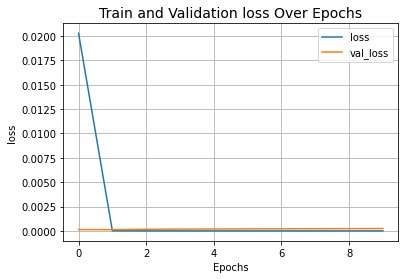

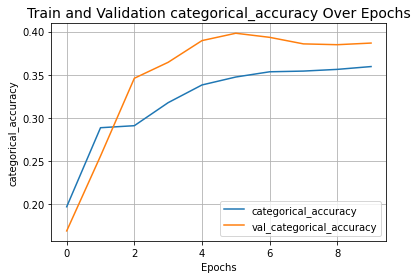

In [82]:
epochs = 10

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["categorical_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)


def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("categorical_accuracy")

## Evaluate the model

In [83]:
_, categorical_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(categorical_acc * 100, 2)}%.")

17/17 [==============================] - 1s 27ms/step - loss: 9.0067e-05 - categorical_accuracy: 0.3579
Categorical accuracy on the test set: 35.79%.


In [84]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, shallow_mlp_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[10:50]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Student notes: {text}")
    print(f"Targets(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_15_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
            
        )
    ][:15]
    print(f"Predicted Targets(s): ({', '.join([label for label in all_labels])})")
    print(" ")

Student notes: b'35 yomc epigastric pain started gradually 2 months ago associated bloating belching associated burning 5 intensity initially relieved tums motrin back pain due lifting heavy weights nausea wakes middle night pain sometimes no waterbrash associated dark stools denies trauma tingling numbness headache swelling vomiting sweating chest pain exersion pain joints urinary changes weight loss associated decreased food intake despite good appetite dur discomfort ros negative except nkda meds tums motrin pmh none psh none fh pud uncle sh smokes 1 ppd occasional alcohol cut exercises sexually active active months ago construction worker'
Targets(s): ['nausea' '35 year' 'male' 'post prandial bloating or fullness with meals'
 'nsaid use or nonsteroidal anti inflammatory drug use'
 'no blood in stool' 'minimal to no change with tums' 'intermittent'
 'getting worse or progressive or symptoms now daily'
 'fhx of pud or family history of peptic ulcer disease'
 'epigastric discomfort' '

# Takeaways
* My model seems to be predicting every target for every case. I will have to look into this tomorrow.

# Here I will conduct word embedding

In [92]:
train_df

,note_id,case,student_notes,clean,targets
4077,21093,2,HPI: 44yo F presenting with chief complaint of...,hpi 44yo f presenting chief complaint irregula...,"[prior normal periods, last pap smear i year a..."
24826,54768,5,"26 y/o F c/o palpittions\r\nBegan 5 yrs ago, i...",26 f c palpittions began 5 yrs ago increasing ...,"[onset 5 years ago, female, no caffeine use, a..."
15465,40704,4,C/C-Nervousness x few weeks\r\nHPI-45 yr old F...,c c nervousness x weeks hpi 45 yr old f c nerv...,"[lack of other thyroid symptoms, anxious or ne..."
12278,37385,3,35 year old male with stomach discomfort\r\n2 ...,35 year old male stomach discomfort 2 months 5...,[fhx of pud or family history of peptic ulcer ...
28331,61366,6,CC: Mr. Smith is a 17 yo M with chest pain\r\n...,cc mr smith 17 yo chest pain woke yesterday ch...,"[subjective fevers, male, 17 year, recent uppe..."
...,...,...,...,...,...
2505,10292,1,SP is a 20yo F who present with RLQ pain for t...,sp 20yo f present rlq pain past 8 10 hours sta...,"[no vaginal discharge, weight loss, not sexual..."
15927,41181,4,45 year old woman with nervousness x2 weeks. S...,45 year old woman nervousness x2 weeks worried...,"[lack of other thyroid symptoms, anxious or ne..."
23749,53658,5,Ms. Whela is a 26YO female without a SPMHx tha...,ms whela 26yo female without spmhx presented f...,"[onset 5 years ago, female, no caffeine use, a..."
12724,37841,3,35 yoM presents to the clinic with 2 months of...,35 yom presents clinic 2 months intermittent e...,[fhx of pud or family history of peptic ulcer ...


## Let's try on case 0.

In [95]:
case0 = train_df[train_df.case == 0]